## LAB3 D: Recurrent + 2D CNN

### Proceedure:

- Make `DataLoader` (this time without set-frame sampling).
- Use frozen EfficientNetB0 for feature extraction.
- Test RNN and LSTM.
- Train and evaluate.

In [1]:
import warnings
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import random

warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [2]:
class UCF50FullRGBDataset(Dataset):
    def __init__(self, rgb_npz_path, transform_rgb=None):
        """
        Full-frame sampling: returns all RGB frames per video.
        rgb_npz_path: path to train/test.npz with RGB frames (H x W x 3)
        transform_rgb: optional torchvision-style transform applied to each frame
        """
        self.rgb_data = np.load(rgb_npz_path, allow_pickle=True)
        self.X_rgb = self.rgb_data['X']
        self.y = self.rgb_data['y']
        self.transform_rgb = transform_rgb

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        rgb_video = self.X_rgb[idx]    # shape: T x H x W x 3
        label = self.y[idx]

        # apply optional transforms
        if self.transform_rgb:
            rgb_video = np.stack([self.transform_rgb(frame) for frame in rgb_video], axis=0)

        # convert to tensor: (T, C, H, W)
        rgb_video = torch.from_numpy(rgb_video).permute(0, 3, 1, 2).float() / 255.0

        return rgb_video, torch.tensor(label, dtype=torch.long)

In [3]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
    """
    Collate function to pad variable-length video sequences in a batch.
    Each batch item: (rgb_frames, label)
    """
    rgb_videos, labels = zip(*batch)  # unzip batch

    # rgb_videos: list of tensors [T, C, H, W]
    lengths = [v.shape[0] for v in rgb_videos]  # original T
    rgb_padded = pad_sequence(rgb_videos, batch_first=True)  # pad along time dim with 0s

    labels = torch.tensor(labels, dtype=torch.long)
    return rgb_padded, labels, torch.tensor(lengths, dtype=torch.long)

BATCH_SIZE = 8

# EfficientNetB0 preprocessing
transform_rgb = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    ),
])

train_dataset = UCF50FullRGBDataset(
    rgb_npz_path="data/UCF50_npz/train.npz",
    transform_rgb=transform_rgb
)

test_dataset = UCF50FullRGBDataset(
    rgb_npz_path="data/UCF50_npz/test.npz",
    transform_rgb=transform_rgb
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=pad_collate
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=pad_collate
)

for rgb_batch, labels, lengths in train_loader:
    print("RGB batch shape:", rgb_batch.shape)  # [B, max_T, 3, H, W]
    print("Labels shape:", labels.shape)        # [B]
    print("Lengths shape:", lengths.shape)      # [B]
    break

RGB batch shape: torch.Size([8, 54, 224, 3, 224])
Labels shape: torch.Size([8])
Lengths shape: torch.Size([8])


[1/10] Train Loss: 1.5031 Acc: 0.3531 | Test Loss: 1.7554 Acc: 0.1288
[2/10] Train Loss: 1.4544 Acc: 0.3855 | Test Loss: 1.7063 Acc: 0.1212
[3/10] Train Loss: 1.3527 Acc: 0.4256 | Test Loss: 1.9481 Acc: 0.1515
[4/10] Train Loss: 1.2150 Acc: 0.4905 | Test Loss: 1.9615 Acc: 0.1894
[5/10] Train Loss: 1.1904 Acc: 0.4981 | Test Loss: 2.3217 Acc: 0.1894
[6/10] Train Loss: 1.1589 Acc: 0.5076 | Test Loss: 2.0943 Acc: 0.1667
[7/10] Train Loss: 1.1557 Acc: 0.5038 | Test Loss: 2.1143 Acc: 0.1591
[8/10] Train Loss: 1.1325 Acc: 0.5115 | Test Loss: 2.4765 Acc: 0.1212
[9/10] Train Loss: 1.0673 Acc: 0.5496 | Test Loss: 2.3748 Acc: 0.1894
[10/10] Train Loss: 1.0983 Acc: 0.5496 | Test Loss: 1.7739 Acc: 0.2197


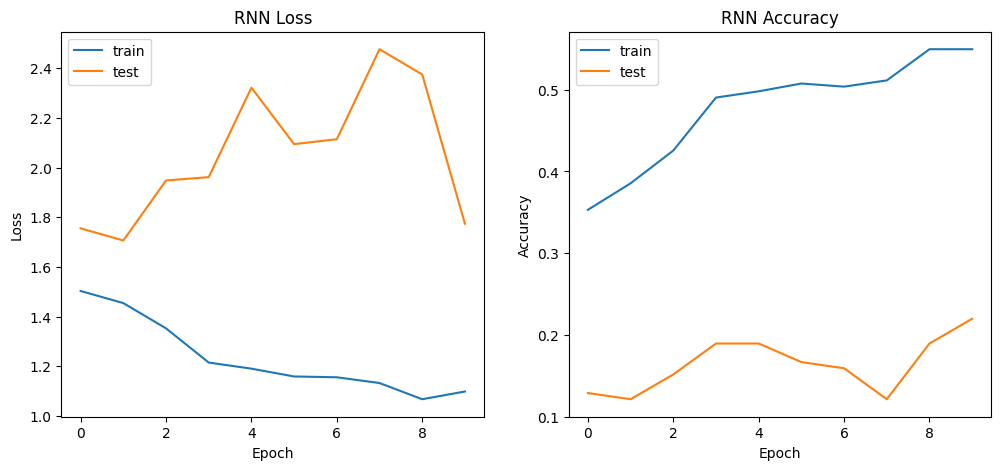

[1/10] Train Loss: 1.5330 Acc: 0.3206 | Test Loss: 1.6369 Acc: 0.1364
[2/10] Train Loss: 1.4564 Acc: 0.3931 | Test Loss: 1.6410 Acc: 0.0606
[3/10] Train Loss: 1.3355 Acc: 0.4542 | Test Loss: 1.6782 Acc: 0.0985
[4/10] Train Loss: 1.2020 Acc: 0.4771 | Test Loss: 1.6606 Acc: 0.1515
[5/10] Train Loss: 1.1811 Acc: 0.5210 | Test Loss: 1.6817 Acc: 0.1364
[6/10] Train Loss: 1.1309 Acc: 0.5286 | Test Loss: 1.6459 Acc: 0.1364
[7/10] Train Loss: 1.0741 Acc: 0.5630 | Test Loss: 1.7138 Acc: 0.1591
[8/10] Train Loss: 1.0297 Acc: 0.5573 | Test Loss: 1.6808 Acc: 0.1364
[9/10] Train Loss: 0.9368 Acc: 0.6202 | Test Loss: 1.8506 Acc: 0.1439
[10/10] Train Loss: 0.8746 Acc: 0.6508 | Test Loss: 1.6706 Acc: 0.1212


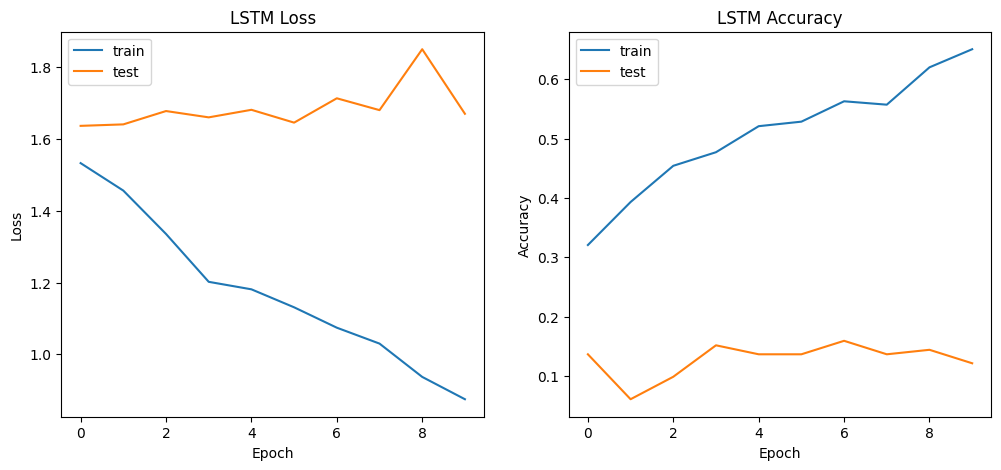

In [4]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms as T
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = len(np.unique(np.load("data/UCF50_npz/train.npz", allow_pickle=True)["y"]))

# ----------------------------
# Define RNN + CNN Model
# ----------------------------
class FrameRNNClassifier(nn.Module):
    def __init__(self, rnn_type='RNN', hidden_size=256, num_layers=1, num_classes=NUM_CLASSES):
        super().__init__()
        # EfficientNetB0 backbone (frozen)
        effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.backbone = effnet.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.feature_dim = 1280  # EfficientNetB0 last channel

        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Temporal RNN
        rnn_cls = nn.RNN if rnn_type=='RNN' else nn.LSTM
        self.rnn = rnn_cls(self.feature_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x, lengths=None):
        B, T, H, C, W = x.shape
        x = x.permute(0, 1, 3, 2, 4).contiguous()  # [B, T, C, H, W]
    
        feats_list = []
        with torch.no_grad():  # backbone frozen
            for v in range(B):
                vid_len = lengths[v] if lengths is not None else T
                frames = x[v, -vid_len:]               # [T_v, C, H, W] (take valid frames)
                f = self.backbone(frames)              # [T_v, 1280, h', w']
                f = self.pool(f).view(vid_len, -1)     # [T_v, feature_dim]
                feats_list.append(f)
    
        # pad sequences to max_T in batch
        feats = pad_sequence(feats_list, batch_first=True)  # [B, max_T, feature_dim]
    
        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(feats, lengths.cpu(), batch_first=True, enforce_sorted=False)
            rnn_out, _ = self.rnn(packed)
            out, _ = nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
            # get last valid hidden state for each video
            idx = (lengths-1).view(-1,1,1).expand(-1,1,out.size(2))
            last_hidden = out.gather(1, idx).squeeze(1)  # [B, hidden_size]
        else:
            rnn_out, _ = self.rnn(feats)
            last_hidden = rnn_out[:, -1, :]
    
        return self.fc(last_hidden)


# ----------------------------
# Training setup
# ----------------------------
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
BATCH_SIZE = 8

# ----------------------------
# Train & Evaluate Function
# ----------------------------
def train_model(rnn_type='RNN'):
    model = FrameRNNClassifier(rnn_type=rnn_type).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, test_losses, train_accs, test_accs = [], [], [], []

    for epoch in range(NUM_EPOCHS):
        # --- Training ---
        model.train()
        running_loss, correct, total = 0, 0, 0
        for rgb_batch, labels, lengths in train_loader:
            rgb_batch, labels, lengths = rgb_batch.to(DEVICE), labels.to(DEVICE), lengths.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(rgb_batch, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()*labels.size(0)
            _, preds = outputs.max(1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)
        train_losses.append(running_loss/total)
        train_accs.append(correct/total)

        # --- Evaluation ---
        model.eval()
        running_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for rgb_batch, labels, lengths in test_loader:
                rgb_batch, labels, lengths = rgb_batch.to(DEVICE), labels.to(DEVICE), lengths.to(DEVICE)
                outputs = model(rgb_batch, lengths)
                loss = criterion(outputs, labels)

                running_loss += loss.item()*labels.size(0)
                _, preds = outputs.max(1)
                correct += (preds==labels).sum().item()
                total += labels.size(0)
        test_losses.append(running_loss/total)
        test_accs.append(correct/total)

        print(f"[{epoch+1}/{NUM_EPOCHS}] "
              f"Train Loss: {train_losses[-1]:.4f} Acc: {train_accs[-1]:.4f} | "
              f"Test Loss: {test_losses[-1]:.4f} Acc: {test_accs[-1]:.4f}")

    # --- Plot Curves ---
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses,label='train'); plt.plot(test_losses,label='test')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'{rnn_type} Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_accs,label='train'); plt.plot(test_accs,label='test')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'{rnn_type} Accuracy'); plt.legend()
    plt.show()

# ----------------------------
# Run experiments
# ----------------------------
train_model('RNN')   # Vanilla RNN
train_model('LSTM')  # LSTM

### Speculations on why the performance is so poor:

Inspecting some of the videos of UCF50, they are about as good as static images, not to mention I also downsampled them both res and fps, therefore most likely these models are too complex for the data, recurrent based approach (time-aware) is probably not needed here or at least require significant tweaks and further engineering